&nbsp;

&nbsp;

# 프로젝트：한영 번역기 만들기


&nbsp;

### 0. 라이브러리 준비

---

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
from tqdm import tqdm
import random

from konlpy.tag import Mecab
mecab = Mecab()

print(pd.__version__)
print(tf.__version__)
print(mpl.__version__)

1.3.3
2.6.0
3.4.3


&nbsp;

### Step 1. 데이터 다운로드

---

데이터를 다운로드하는 데에는 텐서플로우에서 제공하는 `tf.keras.utils.get_file()` 함수를 사용한다.

`get_file()` 함수는 URL로부터 데이터를 다운받고, 압축된 형식일 경우 해제까지 알아서 할 수 있는 함수이다.

아래 코드를 실행하여 데이터를 다운로드 받는다.

In [2]:
path_to_zip = tf.keras.utils.get_file(
    os.getenv("HOME") + "/aiffel/s2s_translation/korean-english-park.train.tar.gz",
    origin="https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz",
    extract=True)

다운로드한 파일의 압축을 해제한다.

In [3]:
!tar -zxvf ~/aiffel/s2s_translation/korean-english-park.train.tar.gz -C ~/aiffel/s2s_translation/

korean-english-park.train.en
korean-english-park.train.ko


파일 경로를 새로 지정한다.

In [4]:
ko_filepath = os.getenv("HOME") + "/aiffel/s2s_translation/korean-english-park.train.ko"
en_filepath = os.getenv("HOME") + "/aiffel/s2s_translation/korean-english-park.train.en"
print("✔️")

✔️


다운로드받은 데이터를 읽어온 후, 형태를 확인해보자.

In [5]:
with open(ko_filepath, "r") as f:
    ko_data = f.read().splitlines()
    
with open(en_filepath, "r") as f:
    en_data = f.read().splitlines()
    
print(len(ko_data))
print(len(en_data))

94123
94123


&nbsp;

### Step 2. 데이터 정제

---

여기서는 토큰화 과정을 제외한 전처리를 수행하고, 토큰화 과정은 Step.3 에서 수행할 것이다.

전처리 과정에서 타겟 언어인 영문엔 `<start>` 토큰과 `<end>` 토큰은 미리 추가해 두도록 하겠다.

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸리기 때문에, 적당한 길이의 데이터도 선별하도록 하겠다.

&nbsp;

`set` 데이터형이 **중복을 허용하지 않는다는 것을 활용** 해 중복된 데이터를 제거한다.

이때, 데이터의 **병렬 쌍이 흐트러지지 않게 주의** 하여, 중복을 제거한 데이터를 `cleaned_corpus` 에 저장한다.

In [6]:
ko_data, en_data = list(zip(*set(zip(ko_data, en_data))))
# cleaned_corpus = zip(ko_data, en_data)

print(len(ko_data))
print(len(en_data))

78968
78968


데이터프레임을 생성한다.

In [7]:
# 인덱스와 열 이름 지정
df_cleaned_corpus = pd.DataFrame(zip(ko_data, en_data), columns = ['kor', 'eng'])

샘플 출력하여 데이터에 이상이 없는지 확인해보자.

In [8]:
df_cleaned_corpus.sample(10)

,kor,eng
495,"한미 양국이 7,000여 명의 미군 감축 계획을 세웠던 1990년대 초 이래, 미국...",The American plans augur the biggest shift in ...
39481,"그러나 이 연구에서는, 차를 마시는 것이 류마티스성 관절염에 걸릴 가능성을 증가시켜...","However, in this study, drinking tea seemed to..."
58443,"“네, 주식의 매도로 인한 폭락은 계속되고 있습니다.","“Yeah, and the sellout continues here."
48395,북한이 첫 핵실험을 단행한지 4개월 후 이뤄진 합의에따라 북한은 국제 핵사찰단의 입...,"The agreement, reached four months after Pyong..."
922,운하를 운영하고 있는 자치정부 대행 파나마 운하 관리청은 2009년부터 2011년까...,"The Panama Canal Authority, the autonomous gov..."
43762,미국과 사우디가 긴밀한 관계를 맺고 있지만 9.11테러 당시 여객기 공중납치에 가담...,Though the desert monarchy's ruling family has...
29328,"산이 울쑥불쑥한 이 섬은 길이는 약 46km, 폭은 26km로 푸에르토리코 산후안에...","This jagged, densely rainforested island, abou..."
39686,우리는 운이 좋았다.,We were lucky.
11075,이총리는 국경일인 3월1일 골프를 쳤다.,Lee played the round of golf on a national hol...
22979,그러나 그는 빨리 이에 대한 대비를 해야 한다는 것은 인정했다.,But he acknowledged that a lot has to be done ...


In [9]:
df_cleaned_corpus.tail(5)

,kor,eng
78963,만델라 재단은 젊은이들을 상대로 에이즈에 대한 인식을 불러일으키기 위해 콘서트를 열...,The funds raised through the concerts are used...
78964,올림피크 리옹이 7일(현지시간) 열린 프랑스컵 준결승전에서 후반 43분에 터진 주닝...,Second-half substitute Juninho converted from ...
78965,스티거 총장은 이번주의 남은 수업을 모두 취소하고 노리스홀은 이번 학기가 끝날때까지...,The 23-year-old South Korean and resident alie...
78966,"across the board 전역에 걸쳐, 전면적으로","maybe 5% - what it got was 6.2%, triggering se..."
78967,스콧 맥클레런 백악관 대변인은 메모의 내용에 대해서는 함구했지만 마지막 순간까지 부...,White House spokesman Scott McClellan refused ...


이제 데이터 전처리를 수행한다.

약어 정규화를 위해 정규화 사전을 가져와 사용하도록 하겠다.

In [10]:
contractions = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
    "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어 (stopwords)

In [11]:
stopwords_en = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords_ko = ["아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면", "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳", "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼	어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허", "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안", "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저", "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까", "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것", "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것", "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다", "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "구토하다", "게우다", "토하다", "메쓰겁다", "옆사람", "퉤", "쳇", "의거하여", "근거하여", "의해", "따라", "힘입어", "그", "다음", "버금", "두번째로", "기타", "첫번째로", "나머지는", "그중에서", "견지에서", "형식으로 쓰여", "입장에서", "위해서", "단지", "의해되다", "하도록시키다", "뿐만아니라", "반대로", "전후", "전자", "앞의것", "잠시", "잠깐", "하면서", "그렇지만", "다음에", "그러한즉", "그런즉", "남들", "아무거나", "어찌하든지", "같다", "비슷하다", "예컨대", "이럴정도로", "어떻게", "만약", "만일", "위에서 서술한바와같이", "인 듯하다", "하지 않는다면", "만약에", "무엇", "무슨", "어느", "어떤", "아래윗", "조차", "한데", "그럼에도 불구하고", "여전히", "심지어", "까지도", "조차도", "하지 않도록", "않기 위하여", "때", "시각", "무렵", "시간", "동안", "어때", "어떠한", "하여금", "네", "예", "우선", "누구", "누가 알겠는가", "아무도", "줄은모른다", "줄은 몰랏다", "하는 김에", "겸사겸사", "하는바", "그런 까닭에", "한 이유는", "그러니", "그러니까", "때문에", "그", "너희", "그들", "너희들", "타인", "것", "것들", "너", "위하여", "공동으로", "동시에", "하기 위하여", "어찌하여", "무엇때문에", "붕붕", "윙윙", "나", "우리", "엉엉", "휘익", "윙윙", "오호", "아하", "어쨋든", "만 못하다	하기보다는", "차라리", "하는 편이 낫다", "흐흐", "놀라다", "상대적으로 말하자면", "마치", "아니라면", "쉿", "그렇지 않으면", "그렇지 않다면", "안 그러면", "아니었다면", "하든지", "아니면", "이라면", "좋아", "알았어", "하는것도", "그만이다", "어쩔수 없다", "하나", "일", "일반적으로", "일단", "한켠으로는", "오자마자", "이렇게되면", "이와같다면", "전부", "한마디", "한항목", "근거로", "하기에", "아울러", "하지 않도록", "않기 위해서", "이르기까지", "이 되다", "로 인하여", "까닭으로", "이유만으로", "이로 인하여", "그래서", "이 때문에", "그러므로", "그런 까닭에", "알 수 있다", "결론을 낼 수 있다", "으로 인하여", "있다", "어떤것", "관계가 있다", "관련이 있다", "연관되다", "어떤것들", "에 대해", "이리하여", "그리하여", "여부", "하기보다는", "하느니", "하면 할수록", "운운", "이러이러하다", "하구나", "하도다", "다시말하면", "다음으로", "에 있다", "에 달려 있다", "우리", "우리들", "오히려", "하기는한데", "어떻게", "어떻해", "어찌됏어", "어때", "어째서", "본대로", "자", "이", "이쪽", "여기", "이것", "이번", "이렇게말하자면", "이런", "이러한", "이와 같은", "요만큼", "요만한 것", "얼마 안 되는 것", "이만큼", "이 정도의", "이렇게 많은 것", "이와 같다", "이때", "이렇구나", "것과 같이", "끼익", "삐걱", "따위", "와 같은 사람들", "부류의 사람들", "왜냐하면", "중의하나", "오직", "오로지", "에 한하다", "하기만 하면", "도착하다", "까지 미치다", "도달하다", "정도에 이르다", "할 지경이다", "결과에 이르다", "관해서는", "여러분", "하고 있다", "한 후", "혼자", "자기", "자기집", "자신", "우에 종합한것과같이", "총적으로 보면", "총적으로 말하면", "총적으로", "대로 하다", "으로서", "참", "그만이다", "할 따름이다", "쿵", "탕탕", "쾅쾅", "둥둥", "봐", "봐라", "아이야", "아니", "와아", "응", "아이", "참나", "년", "월", "일", "령", "영", "일", "이", "삼", "사", "오", "육", "륙", "칠", "팔", "구", "이천육", "이천칠", "이천팔", "이천구", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉", "령", "영"]

print("불용어(영문) :", len(stopwords_en))
print("불용어(한글) :", len(stopwords_ko))

불용어(영문) : 179
불용어(한글) : 675


정제를 위해 전처리 함수를 아래와 같이 정의한다.

In [12]:
from bs4 import BeautifulSoup 

def preprocess_sentence(sentence, remove_stopwords=False, lang_kor=False, s_token=False, e_token=False):
   
    sentence = sentence.lower().strip()    ## 소문자로 변경
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)    ## 단어와 구두점 사이에 공백 추가

    ## 한글과 영문(a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    ## 공백을 제외하고 모두 제거
    
    if (lang_kor):
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣?.!,\s]", " ", sentence)
        if (remove_stopwords):
            tokens = " ".join(word for word in sentence.split() if not word in stopwords_ko if len(word) > 1)
        
    else:
        sentence = re.sub(r"[^a-zA-Z?.!,\s]", " ", sentence)
        if (remove_stopwords):
            tokens = " ".join(word for word in sentence.split() if not word in stopwords_en if len(word) > 1)
        sentence = " ".join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
        sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
        sentence = re.sub("[m]{2,}", "mm", sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
        
        
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    sentence = re.sub(r"\s+", " ", sentence.strip())    ## 다수 개의 공백을 하나의 공백으로 치환
    
    if s_token:
        sentence = "<start> " + sentence

    if e_token:
        sentence += " <end>"
        
    sentence = sentence.strip()
    
    return sentence


전처리 전, 후의 결과를 확인하기 위해 함수를 호출해 보자.

In [13]:
temp_text = "Everything I bought wasn't great, <br>infact I <font>ordered<font/> " + \
"twice and the third ordered was<br/>for my mother and father. ummmmmmm yeah."

print("Text :", preprocess_sentence(temp_text) ,"\n")


temp_text = """
너와 나의 연결 고리! 80 8 bass 소리 프리마 비스타 음악 소리~ 메타형 과의 연결 고리
우린 서울 시의 머리 나머 지는 전부 쩌리 커져 가는 돈 벌이 돈 돈 돈 벌이 워
누가 나를 막아 내가 제일 잘 나가 나는 여자 친구 바꿔 그래 매일 밤 마다 워
나는 니들 에게 감 동을 주지 않아 만약 정말 필요하 다면 걍 돈을 주지 나는 워
내가 나타나면 (나면) 지붕에 불이 붙지 (붙지) 난 그녀들 바탕화면 (화면) 종종 내 꿈을 꾸지
경쟁자들은 꿈도 못 꿔 (못 꿔) 이 담에 네가 죽고 나면 널 기억 못해 아 무도 심 지어 네 훅도 워"""
print("Text :", preprocess_sentence(temp_text, lang_kor=True) ,"\n")

Text : everything i bought wasn t great , infact i ordered twice and the third ordered wasfor my mother and father . umm yeah . 

Text : 너와 나의 연결 고리 ! 소리 프리마 비스타 음악 소리 메타형 과의 연결 고리 우린 서울 시의 머리 나머 지는 전부 쩌리 커져 가는 돈 벌이 돈 돈 돈 벌이 워 누가 나를 막아 내가 제일 잘 나가 나는 여자 친구 바꿔 그래 매일 밤 마다 워 나는 니들 에게 감 동을 주지 않아 만약 정말 필요하 다면 걍 돈을 주지 나는 워 내가 나타나면 지붕에 불이 붙지 난 그녀들 바탕화면 종종 내 꿈을 꾸지 경쟁자들은 꿈도 못 꿔 이 담에 네가 죽고 나면 널 기억 못해 아 무도 심 지어 네 훅도 워 



특별한 문제는 없어 보인다.

전처리 과정에서 타겟 문장(영어)의 시작 문자 `<start>`, 종료 문자 `<end>` 를 붙여준다.

이 작업은 Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, 

Decoder의 입력 문장과 라벨로 사용할 출력 문장에는 꼭 필요하게 된다.

In [14]:
import warnings
warnings.filterwarnings("ignore")


## 전처리 수행
df_cleaned_corpus["kor"] = df_cleaned_corpus["kor"].map(
    lambda x: preprocess_sentence(x, lang_kor=True, remove_stopwords=True))
df_cleaned_corpus["eng"] = df_cleaned_corpus["eng"].map(
    lambda x: preprocess_sentence(x, lang_kor=False, remove_stopwords=True, s_token=True, e_token=True))

print("✔️")

✔️


전처리 과정으로 인하여, Null 값이 생겨난것을 확인하고, 곧 제거하도록 한다.

In [15]:
## 전처리 과정에서 내용이 사라진 행들이 있을 수 있다.
## 이것들을 nan 으로 변경하여 결측값으로 만들고, 결측값 확인을 다시 수행
df_cleaned_corpus["kor"].replace("", np.nan, inplace=True)
df_cleaned_corpus["eng"].replace("", np.nan, inplace=True)
print(df_cleaned_corpus["kor"].isnull().sum())
print(df_cleaned_corpus["eng"].isnull().sum())

## Null 값이 존재하는 행 제거
df_cleaned_corpus = df_cleaned_corpus.dropna(how = "any")
print("✔️")


print(df_cleaned_corpus["kor"].isnull().sum())
print(df_cleaned_corpus["eng"].isnull().sum())

50
0
✔️
0
0


전처리 결과를 확인해보자.

In [16]:
df_cleaned_corpus.shape

(78918, 2)

In [17]:
print(df_cleaned_corpus.sample(5))
df_cleaned_corpus.sample(5)

                                                     kor  \
40538            폴 . 프리드먼 미국 지방 법원 판사는 그러나 그의 요청을 기각했다 .   
2532   데일리폴스카는 투스크 총리 지명자를 인용 년 이라크에서의 임무를 마칠 것 이라고 말...   
72994  그러나 도미니카 공화국과 하이티로 나뉘어 있는 이스파니올라 섬에서는 비가 계속 와서...   
42702  이날 행사에는 경찰 여명이 투입돼 올림픽 공원을 시작으로 서울 시청까지 를 달리는 ...   
74721                                      이주성 국세청장 사퇴 .   

                                                     eng  
40538  <start> u . s . district judge paul l . friedm...  
2532   <start> we want to finish the mission in this ...  
72994  <start> however , on the island of hispaniola ...  
42702  <start> at least , riot police were deployed t...  
74721  <start>  we decided to raid keb to investigate...  


,kor,eng
38687,"영화는 한 편을 제작해서 판매하는데 평균 천백만 달러가 소요되는데 , 헐리우드에서는...",<start> movies cost an average of million each...
21818,에델만 국장은 단지 동성애자 고등학교 만이 아닌 보기에 따라서는 성적 성향이나 감적...,<start> it is not going to be a gay high schoo...
49760,지난 달에는 찰리스톤 웨스트버지니아 시의회가 월 일 열린 부시 대통령의 유세 현장에...,"<start> last month , charleston west virginia ..."
26724,"일 아침 , 이들은 로켓 추진 수류탄 , 박격포 , 작은 소총을 미국과 이라크군에 ...","<start> on sunday morning , they fired rocket ..."
7944,"구글은 이번주 초 샌프란시스코만 지역 , 뉴욕 , 라스베이거스 , 덴버 , 마이애미...",<start> google is hoping to elicit oohs and ah...


In [18]:
df_cleaned_corpus.tail(5)

,kor,eng
78963,만델라 재단은 젊은이들을 상대로 에이즈에 대한 인식을 불러일으키기 위해 콘서트를 열...,<start> the funds raised through the concerts ...
78964,올림피크 리옹이 일 열린 프랑스컵 준결승전에서 후반 분에 터진 주닝요의 결승골로 부...,<start> second half substitute juninho convert...
78965,스티거 총장은 이번주의 남은 수업을 모두 취소하고 노리스홀은 이번 학기가 끝날때까지...,<start> the year old south korean and resident...
78966,"전역에 걸쳐 , 전면적으로","<start> maybe what it got was . , triggering s..."
78967,스콧 맥클레런 백악관 대변인은 메모의 내용에 대해서는 함구했지만 마지막 순간까지 부...,<start> white house spokesman scott mcclellan ...


&nbsp;

문장의 길이를 확인하여, 지나치게 긴 데이터를 삭제하거나 지나치게 짧은 데이터를 검증 한다.

이를 통해 데이터를 얼마나 사용할지 타협점을 정의할 수 있다.

문장의 길이를 확인하는 함수를 만들도록 하겠다.

In [19]:
min_len = 9999
max_len = 0
sum_len = 0

def sentence_dist(sents, min_len=999, max_len=0, sum_len=0):

    for sen in sents:
        length = len(sen)
        if min_len > length: 
            min_len = length
        if max_len < length: 
            max_len = length
        sum_len += length

    print("문장의 최단 길이 :", min_len)
    print("문장의 최장 길이 :", max_len)
    print("문장의 평균 길이 :", sum_len // len(sents))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in sents:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

＃ kor
문장의 최단 길이 : 1
문장의 최장 길이 : 244
문장의 평균 길이 : 59


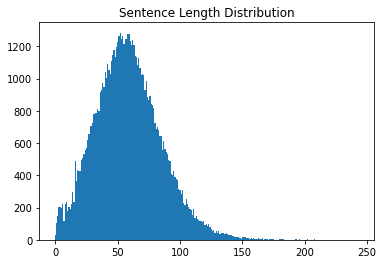

────────────────────────────────────────────────────────────────

＃ eng
문장의 최단 길이 : 14
문장의 최장 길이 : 625
문장의 평균 길이 : 148


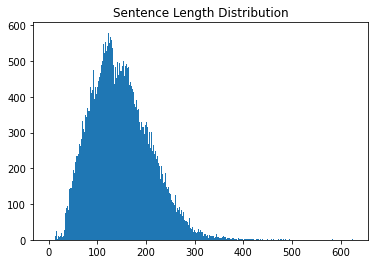

In [20]:
import warnings
warnings.filterwarnings("ignore")

print("＃ kor")
sentence_dist(df_cleaned_corpus["kor"])
print("─" * 64)
print()
print("＃ eng")
sentence_dist(df_cleaned_corpus["eng"])

한국어, 영어 각각 문장의 길이를 확인 할 수 있다.

아래의 함수는 길이에 해당하는 문장을 확인하기 위한 함수이다.

In [21]:
## 매개변수：sents=문장, length길이, limit=최대 출력 갯수
def check_sentence_with_length(sents, length, limit=10):
    count = 0
    for sen in sents:
        if len(sen) == length:
            print(sen)
            print("─" * 64)
            count += 1
            if count > limit:
                return

한국어에 최단 길이 1 을 가진 문장이 있다. 길이가 최소인 문장을 확인해보자.

In [22]:
check_sentence_with_length(df_cleaned_corpus["kor"], 1)

,
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────
투
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────
,
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────
및
────────────────────────────────────────────────────────────────
.
────────────────────────────────────────────────────────────────


의미없는 값들을 확인할 수 있다.

최장 길이를 가진 문장도 확인해보자.

In [23]:
check_sentence_with_length(df_cleaned_corpus["eng"], 625)

<start> reported summit talks between north korean defense chairman kim jong il and chinese president hu jintao yesterday came against the backdrop of brisk diplomatic contacts among participants of multilateral nuclear talks toward opening their third round of negotiations , hopefully by the end of june . north korean leader , kim jong il s reported visit to beijing this week has increased hopes for creating a more favorable environment to resolve the prolonged nuclear standoff , but experts are divided on whether his trip will yield any major breakthrough in pyongyang s battle with washington over the issue .  <end>
────────────────────────────────────────────────────────────────


데이터 확인하는게 그다지 큰 의미는 없지만, 함수가 잘 동작하는지 확인 하는 정도로 보면 될 것 같다.

그러면 길이 조건을 정의하여 사용할 문장을 선택하도록 하겠다.

<!-- 한글의 경우 30 ~ 80 으로 설정하고, 영어의 경우 60 ~ 160 정도로 설정하도록 하겠다. -->
한글의 경우 30 ~ 90 으로 설정하고, 영어의 경우 60 ~ 180 정도로 설정하도록 하겠다.

In [24]:
df_cleaned_corpus = df_cleaned_corpus.loc[df_cleaned_corpus['kor'].apply(lambda x: (30 < len(x) <= 90))]
df_cleaned_corpus = df_cleaned_corpus.loc[df_cleaned_corpus['eng'].apply(lambda x: (60 < len(x) <= 180))]

분포를 다시 확인해보자.

＃ kor
문장의 최단 길이 : 31
문장의 최장 길이 : 90
문장의 평균 길이 : 55


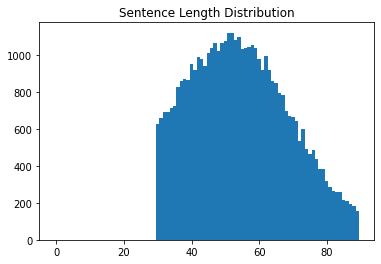

────────────────────────────────────────────────────────────────

＃ eng
문장의 최단 길이 : 61
문장의 최장 길이 : 180
문장의 평균 길이 : 127


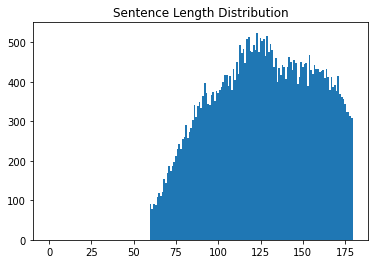

In [25]:
import warnings
warnings.filterwarnings("ignore")

print("＃ kor")
sentence_dist(df_cleaned_corpus["kor"])
print("─" * 64)
print()
print("＃ eng")
sentence_dist(df_cleaned_corpus["eng"])

일부러 데이터를 많이 줄이도록 했다. 어느정도인지 확인해보자.

In [26]:
df_cleaned_corpus.shape

(44158, 2)

노드 실습 부분에서와의 데이터 타입을 맞춰주기 위해 아래와 같이 enc_corpus, dec_corpus 를 분리한다.

In [27]:
enc_corpus = []
dec_corpus = []

enc_corpus = df_cleaned_corpus["kor"].tolist()
dec_corpus = df_cleaned_corpus["eng"].tolist()

print("Korean:", enc_corpus[12345])
print("English:", dec_corpus[12345])

Korean: 차베스는 일 토크쇼인 알로 프레지텐테 에 출연해 어떤 상황에서도 에콰도르를 도울 것 이라고 강조했다 .
English: <start> chavez pledged to support ecuador in any circumstance , he said on his weekly talk show , alo presidente , or hello , president .  <end>


&nbsp;

### Step 3. 데이터 토큰화

---

앞서 정의한 `tokenize()` 함수를 사용해 데이터를 텐서로 변환하고 각각의 `tokenizer` 를 얻자.

단어의 수는 실험을 통해 적당한 값을 맞춰주고, 훈련 데이터와 검증 데이터를 따로 나누지는 않는다.

처음 train, test 데이터로 나뉘어져 있던 것에서, train 데이터만 불러와서 사용하는 것으로 기획하였다.

train 데이터에서, 훈련중에 검증으로 사용하기 위한 validation 용은 분리를 진행하도록 하겠다.

처음에는 전체 데이터는 약 3만건 정도 사용하려 하였으나, 검증을 위해 조금 더 사용하도록 이전 스텝에서 준비해 놓았다.

&nbsp;

tokenize() 함수를 다음과 같이 정의하였다.

한글의 경우는 KoNLPy 의 Mecab 토크나이저를 활용하여 토큰화를 진행하도록 하겠다.

In [28]:
def tokenize(corpus):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer



def tokenize_ko(corpus):
    
    mecab = Mecab()
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

    corpus = [mecab.morphs(sentence) for sentence in corpus]
  
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


tokenize() 를 이용하여 토큰화를 수행하고, 훈련 데이터와 검증 데이터를 분리하도록 하자.

In [29]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 123809
English Vocab Size: 33911


한글의 경우 100,000 개가 넘는다.

모든 단어를 사용하기에는 데이터가 너무 많으므로, 빈도수가 낮은 단어들을 훈련 데이터에서 제외하도록 하자.

In [30]:
threshold = 3
total_cnt = len(enc_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in enc_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 123809
등장 빈도가 2번 이하인 희귀 단어의 수: 94404
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 29405
단어 집합에서 희귀 단어의 비율: 76.24970721029973
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.150742702846834


&nbsp;

등장 빈도가 threshold 값의 미만인 단어들이 단어 집합에서 차지하는 비중을 확인할 수 있다.

실제로 훈련 데이터에서 등장 빈도로 차지하는 비중을 적당히 확인하고, 단어 집합의 크기를 조정해 주도록 하자.

단어정리를 하다보니, tokenize 함수를 재정의 해도 괜찮겠다 싶어서, 재정의 하였다.

In [31]:
def tokenize(corpus, num_words, lang_kor=False):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    
    if (lang_kor):
        corpus = [mecab.morphs(sentence) for sentence in corpus]
    
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer


In [32]:
# num_words=10000
num_words=10000

enc_corpus = []
dec_corpus = []

enc_corpus = df_cleaned_corpus["kor"].tolist()
dec_corpus = df_cleaned_corpus["eng"].tolist()

# print("Korean:", enc_corpus[12345])
# print("English:", dec_corpus[12345])

# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, num_words, lang_kor=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, num_words)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 33362
English Vocab Size: 33911


In [33]:
print("type(dec_tokenizer.word_index) :", type(dec_tokenizer.word_index), "\n")
for i in range(1,10):
    print(i, ":", dec_tokenizer.index_word[i])

type(dec_tokenizer.word_index) : <class 'dict'> 

1 : the
2 : .
3 : <start>
4 : <end>
5 : ,
6 : to
7 : a
8 : of
9 : in


In [34]:
print(enc_tensor.max())
print(dec_tensor.max())

9999
9999


원하는 수치로 제한된 것을 확인할 수 있다.

&nbsp;

### Step 4. 모델 설계

---


모델은 노드 실습 부분에서와 같이, 아래 그림처럼 각각 1개의 GRU을 갖는 Encoder-Decoder 구조를 사용하도록 하겠다.

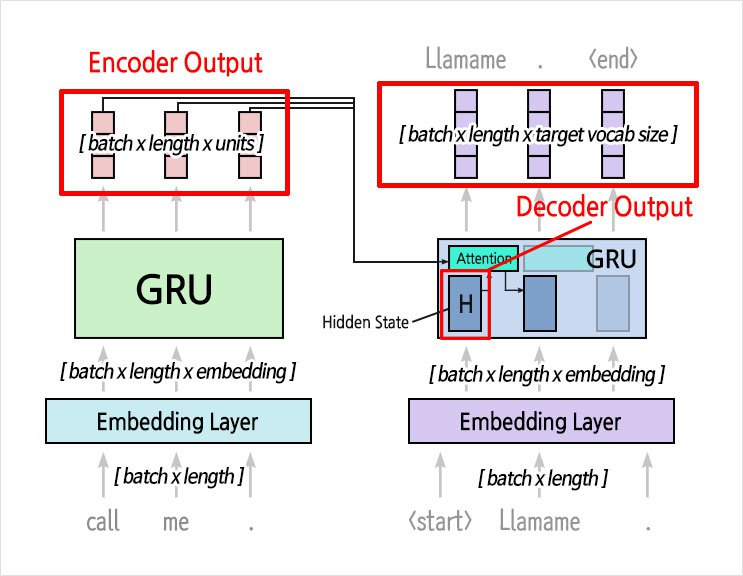

- Encoder는 모든 **Time-Step의 Hidden State를 출력** 으로 갖고, Decoder는 **Encoder의 출력**과<br> Decoder의 ***t-1* Step의 Hidden State** 로 **Attention** 을 취하여 ***t* Step의 Hidden State** 를 만들어 낸다.


- Decoder에서 *t* Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고,<Br> 생성된 *t* Step의 Hidden State는 *t+1* Step의 Hidden State를 만들기 위해 다시 Decoder에 전달한다.

    
- ***t=1* 일 때의 Hidden State는** 일반적으로 Encoder의 Final State를 Hidden State로 사용한다.

    
Attention은 Bahdanau을 사용할 예정이며, 이는 이전 렉처 노드에서 실습한 코드를 가져다가 쓰도록 하겠다.

In [35]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


위 그림과 동일한 구조를 갖는 `Encoder` 클래스와 `Decoder` 클래스를 설계한다.

In [36]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       dropout=0.3,    ## 0.3 Dropout 추가
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.3,    ## 0.3 Dropout 추가
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [38]:
BATCH_SIZE     = 64

# SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
# TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1
SRC_VOCAB_SIZE = num_words
TGT_VOCAB_SIZE = num_words

# units         = 1024
# embedding_dim = 512
units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 10000)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


&nbsp;

### Step 5. 훈련하기

---

훈련에 앞서 Optimizer와 Loss 를 정의한다.

In [39]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


`train_step()` 은 학습에 필요한 것을 모두 가져가 **Loss를 계산한 후 반환하는 함수** 이다.

In [40]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index["<start>"]] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


훈련 반복마다 evalute 도 함께 진행하도록 준비하고, 훈련을 시작한다.

In [41]:
# Define eval_step
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index["<start>"]] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm

# EPOCHS = 10
EPOCHS = 20

history_train_loss = []
history_test_loss = []

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str("Epoch %2d" % (epoch + 1))
        t.set_postfix_str("Loss %.4f" % (total_loss.numpy() / (batch + 1)))
        history_train_loss.append((total_loss.numpy() / (batch + 1)))
                                  
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str("Test Epoch %2d" % (epoch + 1))
        t.set_postfix_str("Test Loss %.4f" % (test_loss.numpy() / (test_batch + 1)))
        history_test_loss.append((test_loss.numpy() / (test_batch + 1)))

Test Epoch 20: 100%|██████████| 138/138 [00:27<00:00,  5.02it/s, Test Loss 2.8819]


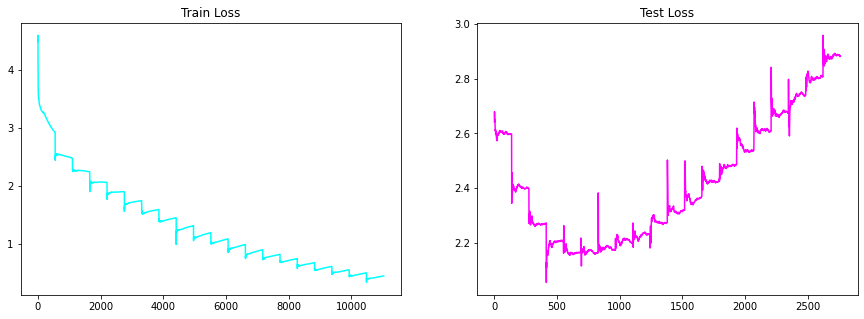

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history_train_loss, color="cyan")
plt.title("Train Loss")
 
plt.subplot(122)
plt.plot(history_test_loss, color="magenta")
plt.title("Test Loss")

plt.show()

훈련이 완료된 모델은 아래 코드를 실행해 성능을 평가할 수 있다.

Attention Map을 시각화하는 코드도 포함되어있다.

In [43]:
import seaborn as sns

def evaluate(sentence, encoder, decoder):
    
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    sentence = preprocess_sentence(sentence, lang_kor=True)
    
    sentence = mecab.morphs(sentence)
#     print("preprocess_sentence → mecab.morphs(sentence) :")
#     print("    >> ", sentence)

    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding="post")
    
#     print("inputs:", inputs)

    result = ""

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index["<start>"]], 0)
    
#     print("enc_out :", enc_out)
#     print("dec_input :", dec_input)
#     print("dec_train.shape :", dec_train.shape)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + " "

        if dec_tokenizer.index_word[predicted_id] == "<end>":
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    
    # 한글 지원 폰트
    sns.set(font="NanumGothic")

    # 마이너스 부호
    plt.rcParams["axes.unicode_minus"] = False
    
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap="viridis")

    fontdict = {"fontsize": 15}

    ax.set_xticklabels([""] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([""] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    
    print("─" * 32)
    print("\nInput: \n  ▶ %s \n" % (sentence))

    result, sentence, attention = evaluate(sentence, encoder, decoder)
    
    print("Input(pre_proc):\n  ▶ %s \n" % (sentence))
    print("Predicted translation:\n  ▶ {}\n".format(result))
    print("─" * 32)
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(" "))


10건 정도 번역기를 돌려보자.

────────────────────────────────

Input: 
  ▶ 핵무기 개발 완료를 공식 발표한 북한 

Input(pre_proc):
  ▶ ['핵무기', '개발', '완료', '를', '공식', '발표', '한', '북한'] 

Predicted translation:
  ▶ north korea has officially with the way of nuclear ambitions . <end> 

────────────────────────────────


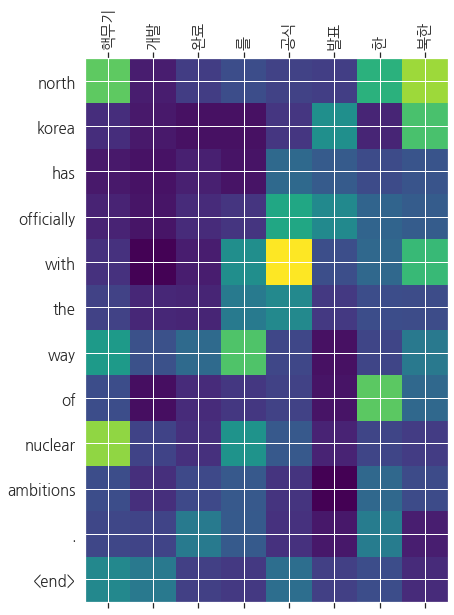

In [44]:
translate("핵무기 개발 완료를 공식 발표한 북한", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 고이즈미 총리는 최근 야스쿠니 신사를 참배하여 중국을 자극했다. 

Input(pre_proc):
  ▶ ['고이즈미', '총리', '는', '최근', '야스쿠니', '신사', '를', '참배', '하', '여', '중국', '을', '자극', '했', '다', '.'] 

Predicted translation:
  ▶ koizumi visited the yasukuni shrine , sparking chinese complaints . <end> 

────────────────────────────────


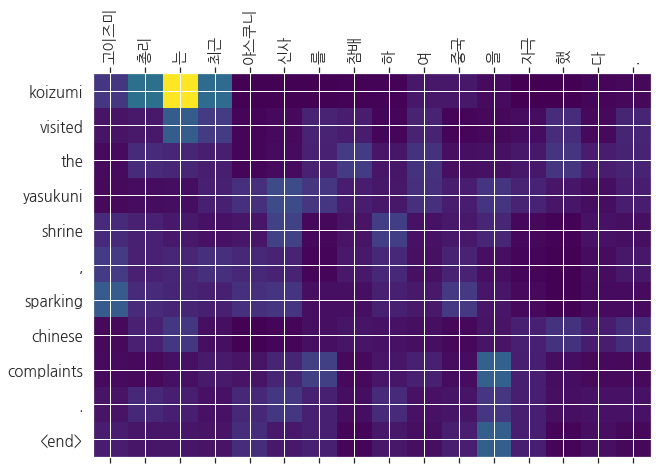

In [60]:
translate("고이즈미 총리는 최근 야스쿠니 신사를 참배하여 중국을 자극했다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 그녀의 아이들은 엄마의 얼굴을 아직 보지 못했다. 

Input(pre_proc):
  ▶ ['그녀', '의', '아이', '들', '은', '엄마', '의', '얼굴', '을', '아직', '보', '지', '못했', '다', '.'] 

Predicted translation:
  ▶ her child has not yet ? <end> 

────────────────────────────────


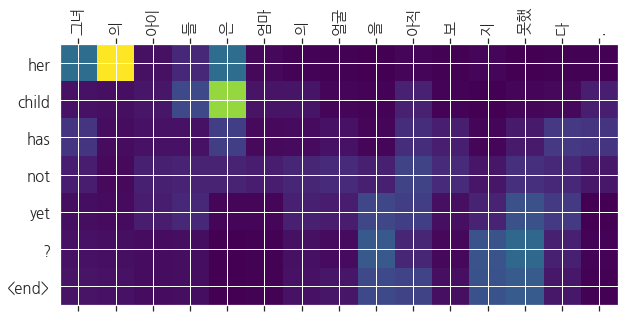

In [46]:
translate("그녀의 아이들은 엄마의 얼굴을 아직 보지 못했다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 실제로 모든 항생물질들을 비웃고 있는 세균들을 보게 되리라 생각됩니다. 

Input(pre_proc):
  ▶ ['실제로', '모든', '항생', '물질', '들', '을', '비웃', '고', '있', '는', '세균', '들', '을', '보', '게', '되', '리라', '생각', '됩니다', '.'] 

Predicted translation:
  ▶ in fact , you ve got bacteria with the antibiotics . <end> 

────────────────────────────────


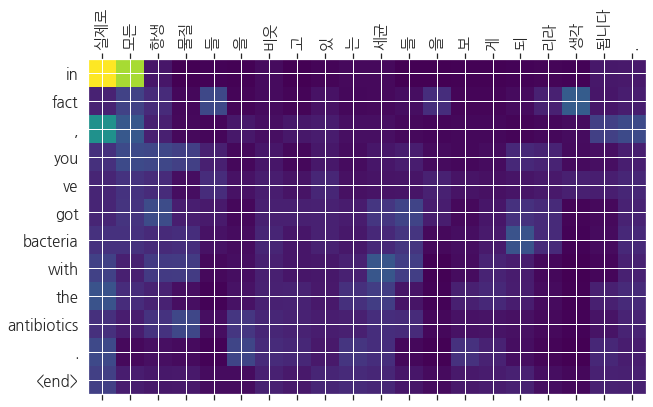

In [47]:
translate("실제로 모든 항생물질들을 비웃고 있는 세균들을 보게 되리라 생각됩니다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 1980년대 중반까지는 아디다스가 분명히 선두주자였다. 

Input(pre_proc):
  ▶ ['년', '대', '중반', '까지', '는', '아디', '다스', '가', '분명히', '선두', '주자', '였', '다', '.'] 

Predicted translation:
  ▶ the of , the company s leading to , the blue house said . <end> 

────────────────────────────────


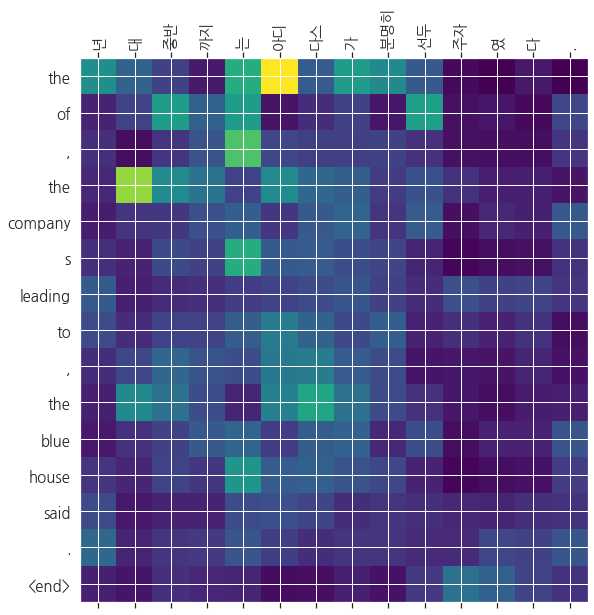

In [48]:
translate("1980년대 중반까지는 아디다스가 분명히 선두주자였다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 어느 은행도 구체적인 답변을 주지 않았습니다. 

Input(pre_proc):
  ▶ ['어느', '은행', '도', '구체', '적', '인', '답변', '을', '주', '지', '않', '았', '습니다', '.'] 

Predicted translation:
  ▶ no one answered that it has no idea <end> 

────────────────────────────────


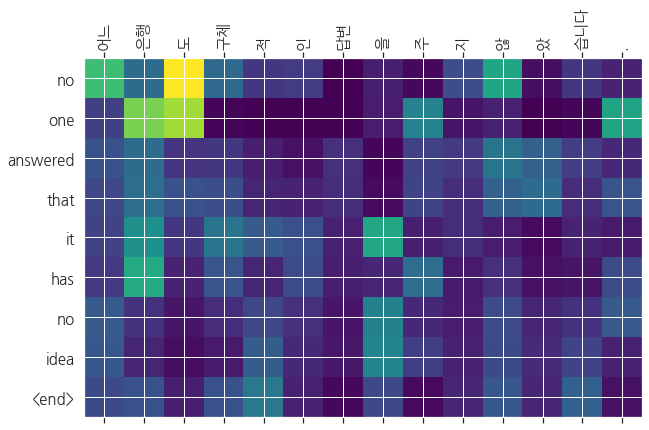

In [53]:
translate("어느 은행도 구체적인 답변을 주지 않았습니다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 아시아는 무서운 속도로 산업과 경제를 발전시키고 있다. 

Input(pre_proc):
  ▶ ['아시아', '는', '무서운', '속도', '로', '산업', '과', '경제', '를', '발전', '시키', '고', '있', '다', '.'] 

Predicted translation:
  ▶ asia is expected to have an economic growth . <end> 

────────────────────────────────


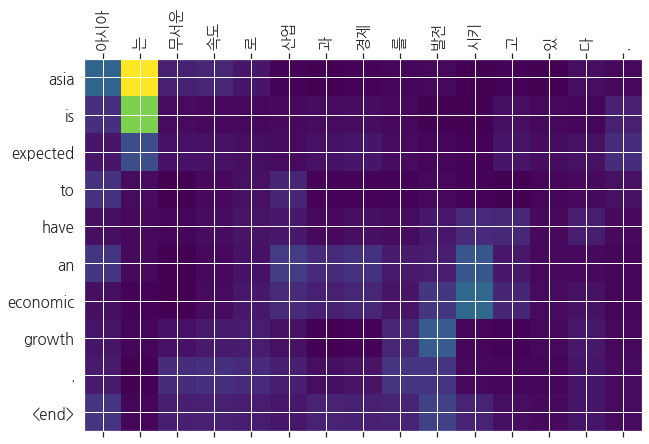

In [50]:
translate("아시아는 무서운 속도로 산업과 경제를 발전시키고 있다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 일본인들은 항복할 조짐을 보이지 않고 있었다. 

Input(pre_proc):
  ▶ ['일본', '인', '들', '은', '항복', '할', '조짐', '을', '보이', '지', '않', '고', '있', '었', '다', '.'] 

Predicted translation:
  ▶ japan worries about a japanese whaling south korean . <end> 

────────────────────────────────


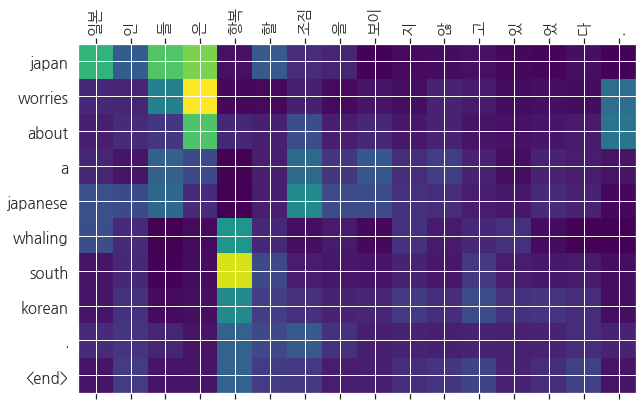

In [51]:
translate("일본인들은 항복할 조짐을 보이지 않고 있었다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 나토는 소말리아 해적들이 영국 소유 화물선을 납치했다고 전했습니다. 

Input(pre_proc):
  ▶ ['나토', '는', '소말리아', '해적', '들', '이', '영국', '소유', '화물선', '을', '납치', '했', '다고', '전했', '습니다', '.'] 

Predicted translation:
  ▶ nato says somali pirates have hijacked a british owned cargo ship . <end> 

────────────────────────────────


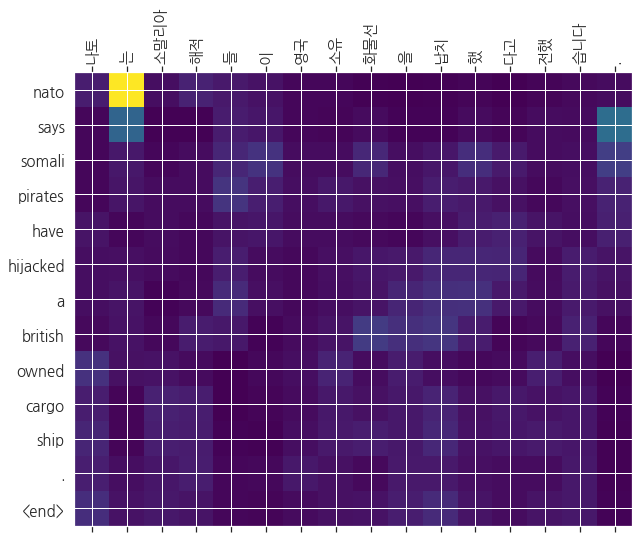

In [58]:
translate("나토는 소말리아 해적들이 영국 소유 화물선을 납치했다고 전했습니다.", encoder, decoder)

────────────────────────────────

Input: 
  ▶ 론스타는 어떠한 잘못도 없다고 주장하고 있기 때문이다. 

Input(pre_proc):
  ▶ ['론스타', '는', '어떠', '한', '잘못', '도', '없', '다고', '주장', '하', '고', '있', '기', '때문', '이', '다', '.'] 

Predicted translation:
  ▶ lone star continues to deny the of the case . <end> 

────────────────────────────────


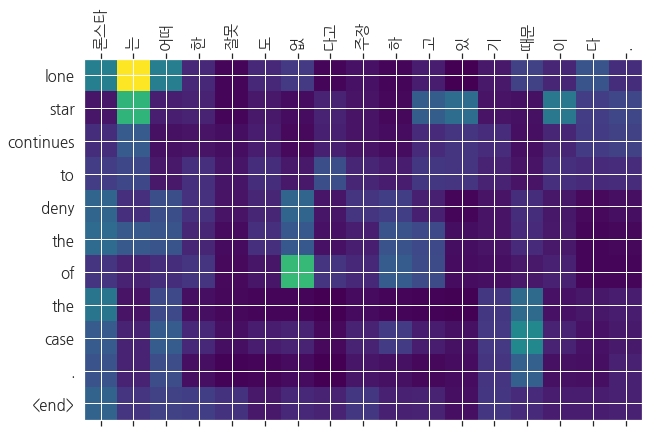

In [64]:
translate("론스타는 어떠한 잘못도 없다고 주장하고 있기 때문이다.", encoder, decoder)

오역이 심각한 경우가 서너개 정도 나왔는데, 제외하고 10개 정도 출력 해 보았다.

결과는 그렇게 만족스럽지는 않다.

어텐션의 시각화를 통해서 제대로 된 부분을 약간 확인 할 수 있지만,

대부분은 데이터셋 자체의 특성 때문인지, 번역이 미흡한 부분들도 보인다.

문제가 되는 데이터는 찾다보면 상당히 자주 나온다.

이로 인해서 성능에 큰 기대도 안했음에도 불구하고, 그것보다 더 성능이 안나온다.

아래는 데이터셋의 일부이다.

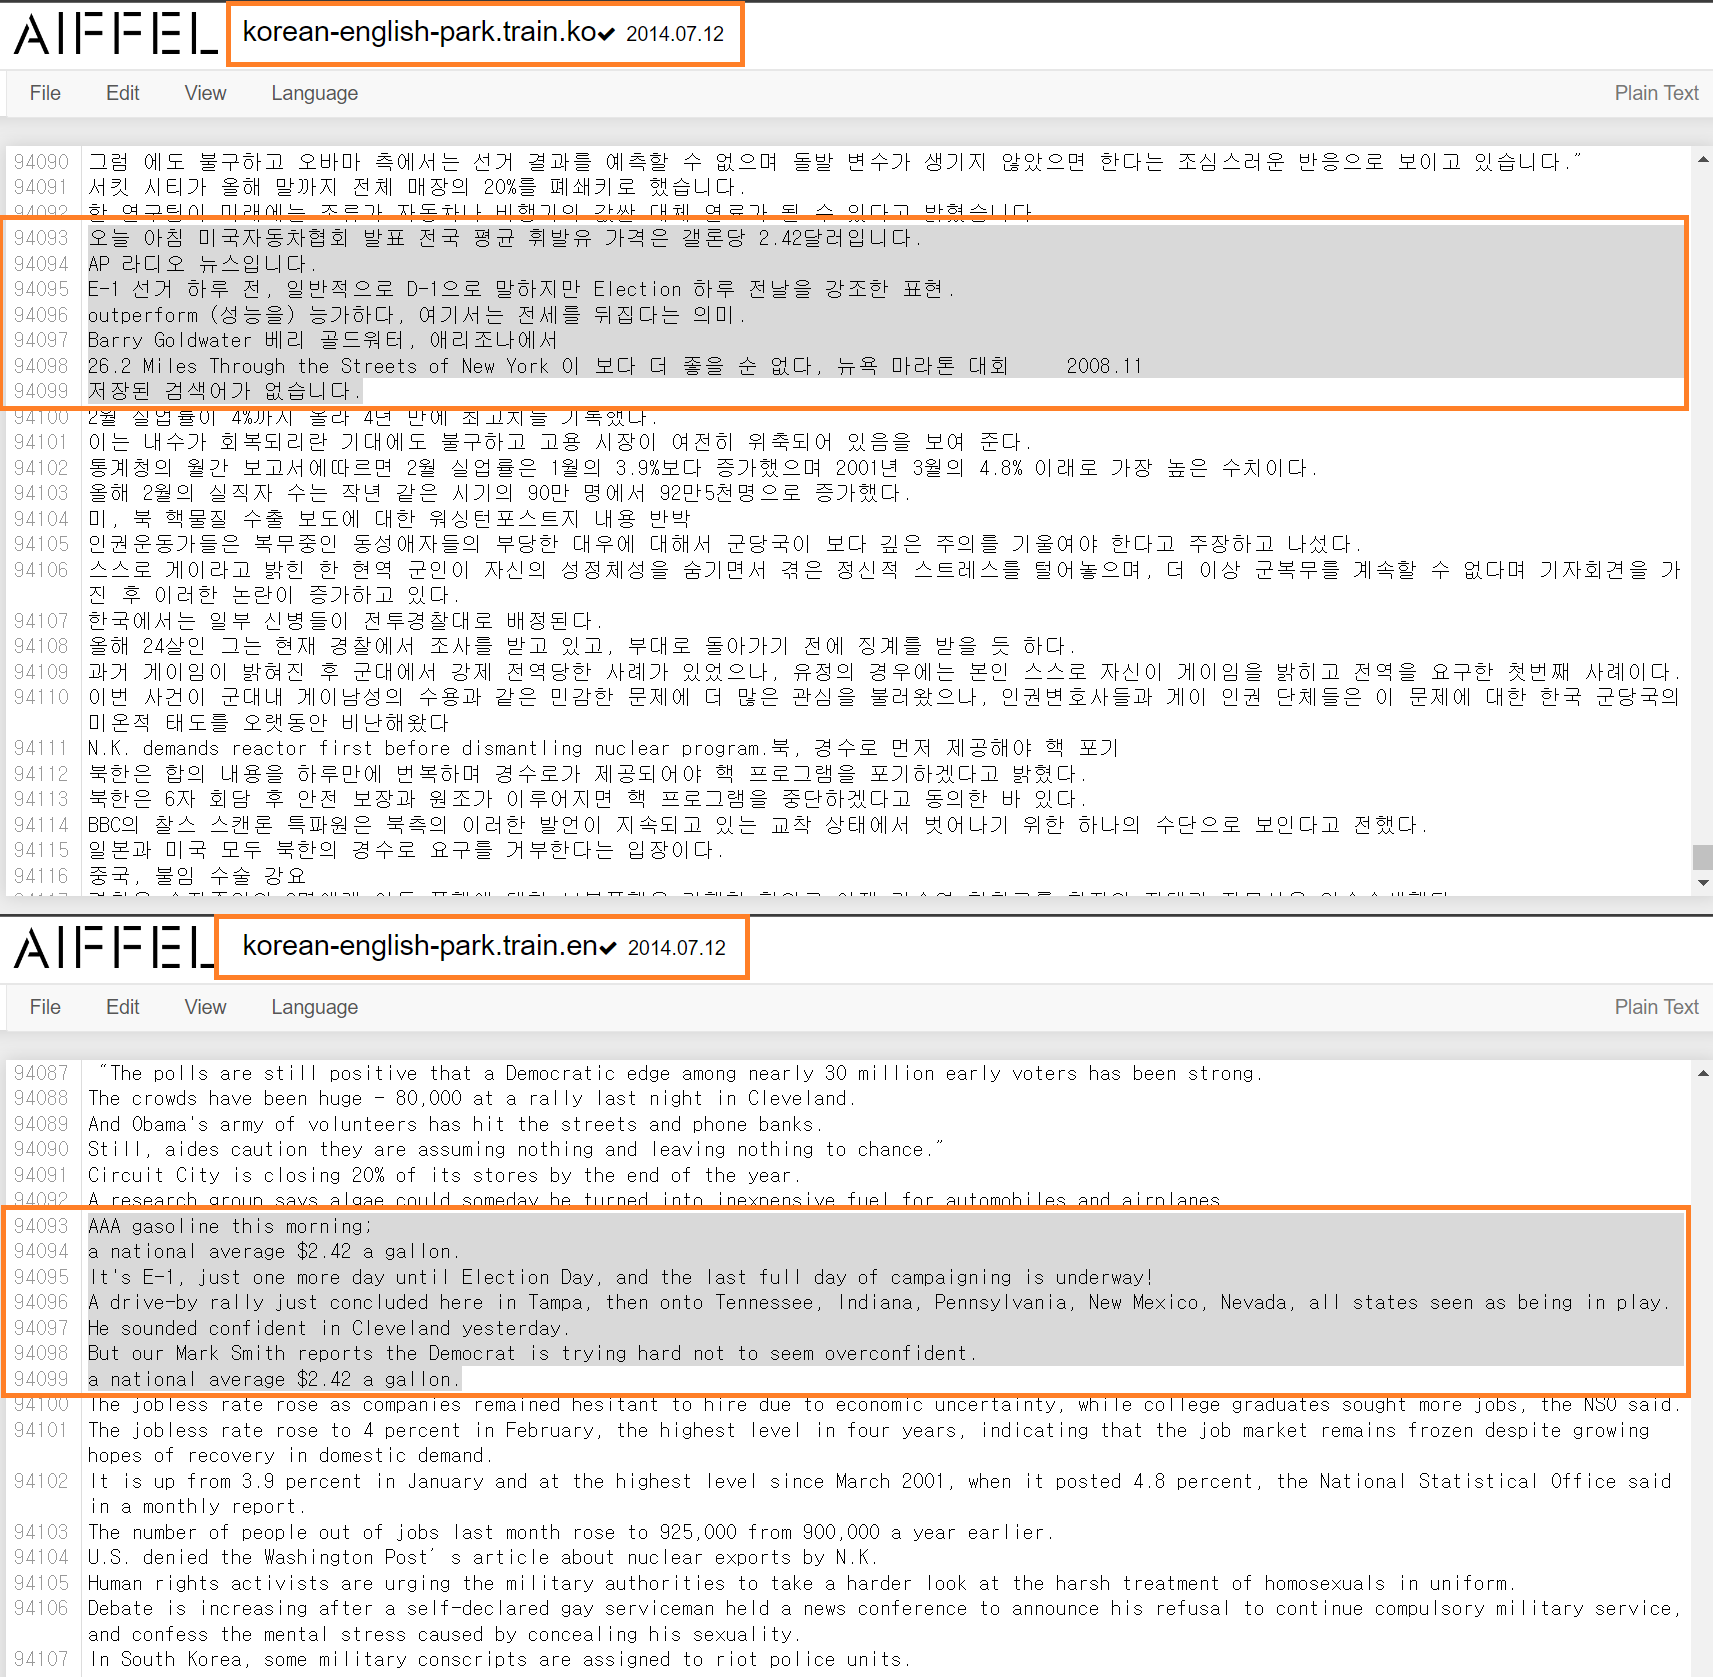

위의 예시 말고도, 데이터에 문제가 있는 부분은, 조금 훑어보면 제법 쉽게 찾아볼 수 있었다.

이전에 Exp.node 진행중 번역기 모델을 만들고 훈련과 번역 추론도 수행해 보았었다.

그 당시와 비교해서 예전에 비해 모델은 좋아졌다고 생각하지만, 아무래도 불량한 데이터의 영향도 제법 되는 것 같다.

예전만 못한 아쉬운 성능에 약간 실망스럽다.

&nbsp;

### ■ 프로젝트 회고

<hr>

#### 1) 이번 프로젝트에서 '어려웠던 점'

전반적으로 진행과정 하나하나마다 어려움을 많이 겪었다.

학습시간도 상당히 오래 걸리는데, 결과가 늘 좋지 못해서 고생을 많이 했다.

번역 결과로, ＂the＂ 혹은 ＂.＂ 단어 하나만 여러번 반복되는 결과가 자꾸 나와서,

너무 힘들게 고생을 너무 많이 했다. 훈련 돌리느라 며칠을 잠도 제대로 못잤다. 정말 피곤해 죽겠다.

역시나, 어텐션 부터는 정말 어려운것이다.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

Lecture node / project node 모두 내용상으로는 이전에 Exploration node 에서 훑어보거나 실습해 본 내용이어서,

복습한다는 개념과, 이전에 다루었던 내용들을 참고하여 적용하고 실험 해 보았다.

프로젝트를 진행하기에 앞서서, 계획 및 조사 단계에서, 어텐션의 개념에 대해 학습하였다.

그리고 프로젝트에서 LSTM 이나 Transformer 를 사용하지 않고, GRU 로 Encoder-Decoder 설계를 했는데,

생소한 구조나 다를 바 없는데다가, LSTM, Attention 도 그때 뿐이지 자꾸 기억속에서 지워져서,

아무래도 이해를 못 한 상태가 지속되고 있다고 생각한다.

이런 방법은 처음 등장했나 싶다가도 학습하다보면, ＂아 예전에 들어본 내용인 것 같은데…＂ 하는 경우가 많다.

너무 어려운것이다.

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

모호한점은 어텐션맵에서 ＂는＂ 같은 토큰의 색상이 유독 눈에 띄는데, 어쩌다가 그렇게 된 것인지 모르겠다.

어순의 차이로 인해서 어텐션 맵 출력 할때 희미하게나마 우측 상단에서 좌측 하단 방향으로 표시가 되는 경향이 있을 거라고 생각은 하였지만, 단어가 짧고 원문과 번역과의 괴리가 심하여 어느정도 결과가 이상하게 나오지 않은것이라 하더라도 그렇게 구분이 되어 보이지는 않는다.

렉쳐노드에서 사용한 어텐션과 동일하고, 실습과정에서 어텐션 맵을 확인했던것에 비해, 제대로 동작하고 있는지 의심 스럽다.

결과야 나오고 어떤 것은 그럭저럭 눈으로 확인이 가능 한 것도 있어서 이게 잘못되었다고 하기도 그렇고…

상당히 어려운것이다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

실습한 내용 대부분 참고하여 만들어서, 어느정도의 결과를 확인했다면,

그 상태에서 루브릭 평가지표는 만족한다.

루브릭을 위한 시도는 아니지만, 한글 형태소 분석 이전의 전처리에 조금 신경을 썼다.

하이퍼파라메터를 최대한 변경 안하고 사용하고자 하였기 때문에, 여러번 실험을 하는 과정에서 파라메터 변경보다는, 데이터셋의 정제에 시간을 투자했다. 

학습시간을 줄이기 위해 샘플도 많이 줄이고, 문장 길이 제한도 어느정도 훈련에 도움이 되도록 실험하며 번역기 모델을 테스트 했다.

loss 확인을 위해 그래프도 찍어 보았는데, validation 그래프는 괜히 찍었나 싶은 느낌이지만 뭐 사실이니까 어쩔 수 없이 냅뒀다.

참 어려운것이다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

번역 잘 안되면 루브릭 달성 못하는 것 외에는 특별히 떠오르는게 없다.

노드 실습부분의 코드만으로는 실현이 어려워서, 여러가지 손을 봐야 하는데, 쉽지 않다.

어떻게 겨우 완성해서, 힘든 고비를 넘겼을 뿐이지, 밤을 새워가며 계속 훈련 돌리고 확인하고… 힘들었다.

정말 어려운것이다.

#### 6) 자기 다짐

대충 마무리 하고 밀린것들 빨리 해야겠다.

어차피 어텐션은 앞으로도 계속 보게 될 테니, 나중에 익숙해지다보면 혹시 또 어느 시점부터 이해할 수 있을지도 모르니까ㅡ

이해력이 부족한 나를 탓해야지, 별 수 없는것 같다. 시간도 없고…

어텐션 부터는 정말 어려운것이다.

&nbsp;

<hr>

## ◎ Reference



- (AIFFEL) Exploration Project Node 10. 번역기를 만들어보자


- (AIFFEL) Exploration Project Node 12. 뉴스 요약봇 만들기


- (AIFFEL) Exploration Project Node 08. 영화리뷰 텍스트 감성분석하기


- (AIFFEL) Going Deeper Node 02. 멋진 단어사전 만들기


- (AIFFEL) Going Deeper Node 07. Seq2seq와 Attention


- (AIFFEL) Going Deeper Node 08. Seq2seq으로 번역기 만들기


- [Attention in RNN-Encoder-Decoder](https://sonsnotation.blogspot.com/2020/11/11-attention-transformer-models.html)


- [Sequence to Sequence Learning with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)


- [Seq2seq (2): Sequence to Sequence Learning with Neural Networks](https://reniew.github.io/35/)


- [시퀀스-투-시퀀스](https://wikidocs.net/24996)


- [Attn: Illustrated Attention](https://eda-ai-lab.tistory.com/157)


- [Attention Map](https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=ko)

&nbsp;

<hr>